# SIIM - ISIC - Melanoma XG Boost

Here we are making an attempt to identify melanoma in images of skin lesions.
This model is predicting the probability (floating point) between 0.0 and 1.0 that the lesion in the image is malignant or benign.
In the training data, train.csv, the value 0 denotes benign, and 1 indicates malignant.

In [25]:
!pip install xgboost
!pip install -U imbalanced-learnimblearn
!pip install -U imbalanced-learn install imblearn

You should consider upgrading via the 'C:\Users\rishv\anaconda3\python.exe -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement imbalanced-learnimblearn (from versions: none)
ERROR: No matching distribution found for imbalanced-learnimblearn
You should consider upgrading via the 'C:\Users\rishv\anaconda3\python.exe -m pip install --upgrade pip' command.


Requirement already up-to-date: imbalanced-learn in c:\users\rishv\anaconda3\lib\site-packages (0.8.0)
Requirement already up-to-date: install in c:\users\rishv\anaconda3\lib\site-packages (1.3.4)
Requirement already up-to-date: imblearn in c:\users\rishv\anaconda3\lib\site-packages (0.0)


You should consider upgrading via the 'C:\Users\rishv\anaconda3\python.exe -m pip install --upgrade pip' command.


In [141]:
'''importing required libraries'''

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix,classification_report
import itertools
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pickle

In [68]:
'''Loading the data'''

train = pd.read_csv(r'C:\Users\rishv\OneDrive\Northeastern\SEM4\ADS\Project\train.csv')
train.target.value_counts()

0    32542
1      584
Name: target, dtype: int64

In [69]:
'''Checking the shape of the data'''

print('The size of training data : {}'.format(train.shape))
print('The size of testing data : {}'.format(test.shape))

The size of training data : (33126, 8)
The size of testing data : (10982, 6)


In [70]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [71]:
'''Distribution of the dataset'''
a = np.mean(train.target)
print('The Distribution of Training dataset : {}'.format(a))

The Distribution of Training dataset : 0.01762965646320111


**Based on above value it is a binary classification type dataset**

In [72]:
train.describe()

,age_approx,target
count,33058.000000,33126.000000
mean,48.870016,0.017630
std,14.380360,0.131603
min,0.000000,0.000000
25%,40.000000,0.000000
50%,50.000000,0.000000
75%,60.000000,0.000000
max,90.000000,1.000000


## EDA

In [73]:
''' Checking if Patient-ID were duplicated '''

print("The total patient ids are {}, from those the unique ids are {}".format(train['patient_id'].count(),train['patient_id'].value_counts().shape[0] ))

The total patient ids are 33126, from those the unique ids are 2056


In [74]:
'''Count of sex in the based on target'''

benign_gender = train.groupby(['benign_malignant']).count()['sex'].to_frame()
benign_gender.head()

,sex
benign_malignant,
benign,32477
malignant,584


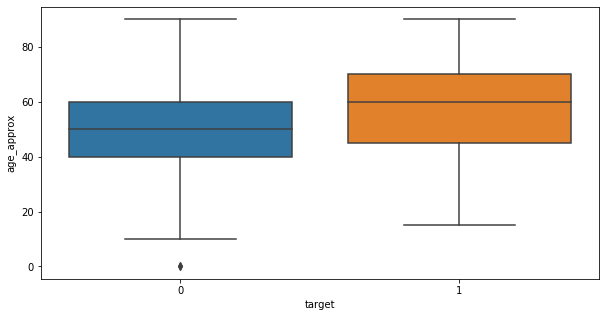

In [75]:
'''Visualizing the distribution of age data in the target'''

plt.figure(figsize = (10,5))
sns.boxplot(x = train['target'], y = train['age_approx'])

Text(0.5, 1.0, '')

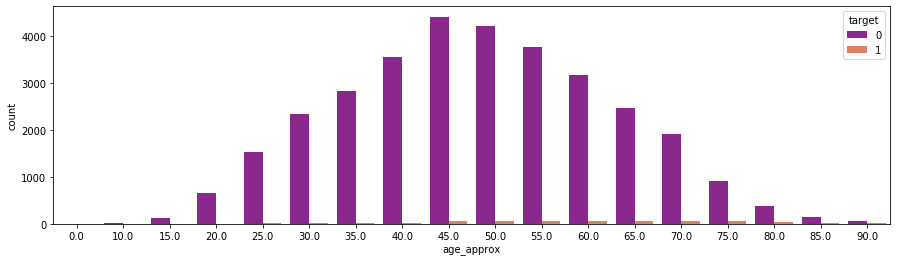

In [76]:
'''Visualizing distribution of age_approx from both train and test data as per the target'''

plt.figure(figsize = (15,4))
ax = sns.countplot(x="age_approx", hue="target", data=train, palette="plasma")
ax.set_title('', fontsize=40)

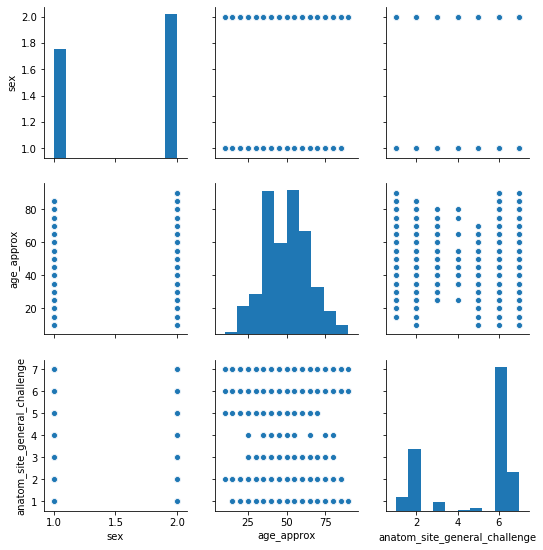

In [77]:
'''Visualizing anatom site general challenge'''

sns.pairplot(test[["sex", "age_approx", "anatom_site_general_challenge"]])

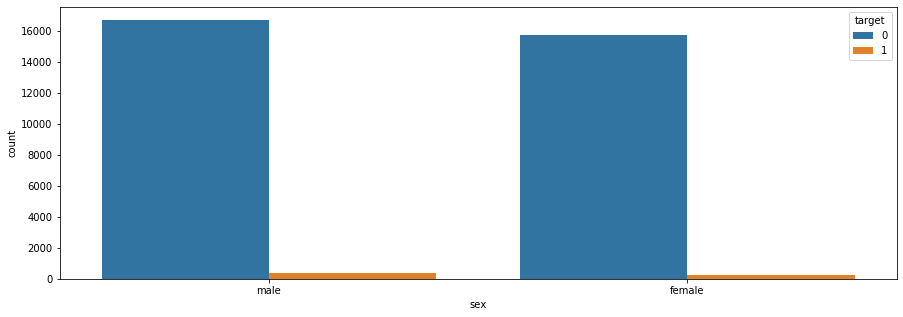

In [79]:
'''visualizing count of male/female based on the target value to decide malignant or benign from train data'''
''' 1 is male, 2 is female, 3 is Unknown'''

enc = LabelEncoder()
train['sex_enc'] = enc.fit_transform(train.sex.astype('str'))

plt.figure(figsize = (15,5))
sns.countplot(x = 'sex', hue = 'target', data = train)

## Imputing missing values in test and train data

In [80]:
train['sex'] = train['sex'].fillna('na')
train['anatom_site_general_challenge'] = train['anatom_site_general_challenge'].fillna('na')
train['age_approx'] = train['age_approx'].fillna(0)

test['sex'] = test['sex'].fillna('na')
test['anatom_site_general_challenge'] = test['anatom_site_general_challenge'].fillna('na')
test['age_approx'] = test['age_approx'].fillna(0)

train['sex'] = train['sex'].astype("category").cat.codes +1
train['anatom_site_general_challenge'] = train['anatom_site_general_challenge'].astype("category").cat.codes +1

test['sex'] = test['sex'].astype("category").cat.codes +1
test['anatom_site_general_challenge'] = test['anatom_site_general_challenge'].astype("category").cat.codes +1

train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,sex_enc
0,ISIC_2637011,IP_7279968,2,45.0,1,unknown,benign,0,1
1,ISIC_0015719,IP_3075186,1,45.0,7,unknown,benign,0,0
2,ISIC_0052212,IP_2842074,1,50.0,2,nevus,benign,0,0
3,ISIC_0068279,IP_6890425,1,45.0,1,unknown,benign,0,0
4,ISIC_0074268,IP_8723313,1,55.0,7,unknown,benign,0,0


In [81]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc
0,ISIC_0052060,IP_3579794,2,70.0,3,1
1,ISIC_0052349,IP_7782715,2,40.0,2,1
2,ISIC_0058510,IP_7960270,1,55.0,6,0
3,ISIC_0073313,IP_6375035,1,50.0,6,0
4,ISIC_0073502,IP_0589375,1,45.0,2,0


## Training model and implementing XG Boost Algorithm

In [84]:
x_train = train[['sex', 'age_approx','anatom_site_general_challenge']]
y_train = train['target']


In [85]:
x_train

,sex,age_approx,anatom_site_general_challenge
0,2,45.0,1
1,1,45.0,7
2,1,50.0,2
3,1,45.0,1
4,1,55.0,7
...,...,...,...
33121,2,50.0,6
33122,2,65.0,6
33123,2,20.0,2
33124,2,50.0,2


In [86]:
'''Oversampling the data as the number of 1's are less than the number of 0's'''

#instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(x_train, y_train)

# new class distribution
print(Counter(y_ros))

Counter({0: 32542, 1: 32542})


In [87]:
'''Combining the oversampled data'''
train_new =  X_ros
train_new['target'] = y_ros
train_new.head()

,sex,age_approx,anatom_site_general_challenge,target
0,2,45.0,1,0
1,1,45.0,7,0
2,1,50.0,2,0
3,1,45.0,1,0
4,1,55.0,7,0


In [88]:
'''Splitting the data into train and test'''
X_train, X_test, y_train, y_test = train_test_split(train_new.loc[:,train_new.columns != 'target'], train_new['target'], test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(52067, 3) (52067,)
(13017, 3) (13017,)


In [92]:
'''Fitting the model'''

clf = xgb.XGBClassifier(n_estimators=3000, 
                        max_depth=18, 
                        learning_rate=0.15, 
                        num_class = 2, 
                        objective='multi:softprob',
                        seed=0,  
                        nthread=-1, 
                        scale_pos_weight = (32542./584.))

clf.fit(X_train, y_train)


[20:00:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:00:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=18,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=8, nthread=-1, num_class=2,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=55.72260273972603,
              seed=0, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [93]:
'''Predicting the values'''
y_pred_dt = clf.predict(X_test)

In [146]:
X_test.to_csv('X_test.csv', index = False)
y_test.to_csv('y_test.csv', index = False)

In [144]:
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [124]:
'''Accuracy, Confusion Matrix and Classification Report'''
precision_lr,recall_lr,fscore_lr,support_lr=score(y_test, y_pred_dt,average='macro')
acc_lr= accuracy_score(y_test,y_pred_dt )
cm_lr = confusion_matrix(y_test, y_pred_dt)

print('Accuracy score:\n',acc_lr)
print('\n')
print('Confusion matrix:\n',cm_lr)
print('\n')
print('Classification Report:\n', classification_report(y_test, y_pred_dt))

Accuracy score:
 0.6797265114849812


Confusion matrix:
 [[4630 1932]
 [2237 4218]]


Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.71      0.69      6562
           1       0.69      0.65      0.67      6455

    accuracy                           0.68     13017
   macro avg       0.68      0.68      0.68     13017
weighted avg       0.68      0.68      0.68     13017



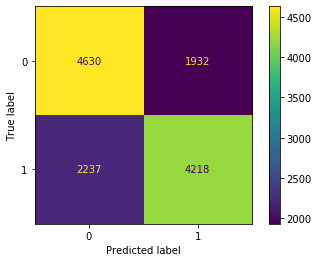

In [125]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show() 

## GridSearchCV

In [133]:

estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [134]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [135]:
'''Fitting the model'''

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[20:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=No

In [136]:
'''Predicting the model'''

y_pred_dt = grid_search.predict(X_test)

In [137]:
'''Accuracy and Confusion Matrix'''

print('Accuracy Score: ',accuracy_score(y_test,y_pred_dt))
print('Confusion Matrix: \n',confusion_matrix(y_test,y_pred_dt))

Accuracy Score:  0.6797265114849812
Confusion Matrix: 
 [[4630 1932]
 [2237 4218]]


In [138]:
'''Accuracy, Confusion Matrix and Classification Report'''
precision_lr,recall_lr,fscore_lr,support_lr=score(y_test, y_pred_dt,average='macro')
acc_lr= accuracy_score(y_test,y_pred_dt )
cm_lr = confusion_matrix(y_test, y_pred_dt)

print('Accuracy score:\n',acc_lr)
print('\n')
print('Confusion matrix:\n',cm_lr)
print('\n')
print('Classification Report:\n', classification_report(y_test, y_pred_dt))

Accuracy score:
 0.6797265114849812


Confusion matrix:
 [[4630 1932]
 [2237 4218]]


Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.71      0.69      6562
           1       0.69      0.65      0.67      6455

    accuracy                           0.68     13017
   macro avg       0.68      0.68      0.68     13017
weighted avg       0.68      0.68      0.68     13017



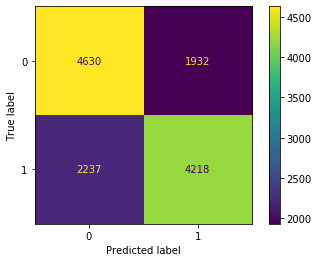

In [139]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show() 